In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import sys
sys.path.append('..')

In [3]:
swissprot = pd.read_parquet('/projects/bpms/pstjohn/swissprot/parsed_swissprot_uniref_clusters.parquet')
go_terms = pd.read_parquet('/projects/bpms/pstjohn/swissprot/swissprot_quickgo.parquet')

In [4]:
import numpy as np
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]

In [6]:
uniref50_clusters = swissprot_annotated['UniRef50 ID'].unique()
print(len(uniref50_clusters))
np.random.shuffle(uniref50_clusters)
test, valid, train = np.split(uniref50_clusters, [4000, 8000])

174018


In [7]:
swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(train)].sample(frac=1.)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(valid)].sample(frac=1.)

In [8]:
go_terms.head()

,GENE PRODUCT DB,GENE PRODUCT ID,SYMBOL,QUALIFIER,GO TERM,GO ASPECT,ECO ID,GO EVIDENCE CODE,REFERENCE,WITH/FROM,TAXON ID,ASSIGNED BY,ANNOTATION EXTENSION,DATE
0,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571|InterPro:IPR018354,8613,InterPro,None,20200613
1,UniProtKB,A2CKF6,A2CKF6,involved_in,GO:0009405,P,ECO:0000256,IEA,GO_REF:0000002,InterPro:IPR003571,8613,InterPro,None,20200613
2,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0005576,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0964,8613,UniProt,None,20200613
3,UniProtKB,A2CKF6,A2CKF6,enables,GO:0090729,F,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0800,8613,UniProt,None,20200613
4,UniProtKB,A2CKF6,A2CKF6,part_of,GO:0035792,C,ECO:0000322,IEA,GO_REF:0000043,UniProtKB-KW:KW-0629,8613,UniProt,None,20200613


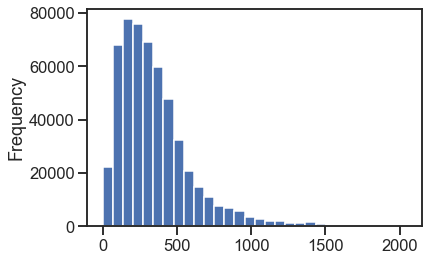

In [9]:
swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [10]:
from bert.go import Ontology
ont = Ontology(threshold=500)
ont.total_nodes

3181

In [11]:
grouped_go_terms = go_terms.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)

In [12]:
from tqdm.autonotebook import tqdm

/projects/rlmolecule/pstjohn/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [13]:
from bert.dataset import encode

In [22]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.
max_seq_len=1520
fix_seq_len=True

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _serialize_array(value):
    return _bytes_feature(tf.io.serialize_tensor(value))

def inputs_generator(swissprot_df):
    for _, row in tqdm(swissprot_df.iterrows(), total=len(swissprot_df)):
        sequence = encode(row.sequence, max_seq_len)
        ancestor_array = ont.termlist_to_array(ont.get_ancestors(
            grouped_go_terms[row.accession]), dtype=float)
        
        features = {
            'sequence': _serialize_array(sequence),
            'annotation': _serialize_array(ancestor_array)
        }
        
        example_proto = tf.train.Example(features=tf.train.Features(feature=features))
        yield example_proto.SerializeToString()


# Preprocess and write the train dataset to disk
serialized_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_train),
    output_types=tf.string, output_shapes=())

filename = '/projects/bpms/pstjohn/swissprot/go_train.tfrecord.gz'
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_train_dataset)


# Preprocess and write the valid dataset to disk
serialized_valid_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(swissprot_valid),
    output_types=tf.string, output_shapes=())

filename = '/projects/bpms/pstjohn/swissprot/go_valid.tfrecord.gz'
writer = tf.data.experimental.TFRecordWriter(filename, compression_type='GZIP')
writer.write(serialized_valid_dataset)

In [26]:
pd.Series(ont.term_index).to_csv('term_index.csv')